# TITANIC SHIPWRECK SURVIVAL PREDICTION

### Overview

This is the popular machine learning competition on Kaggle; We are to create a model that predicts the passengers survived the infamous Titanic shipwreck.

We are provided with two datasets; the training set and the test set.
The `training` set would be used to build the machine learning model while the `test` set would be used to see how well the model will perform on unseen data.

### Importing the required Libraries for the project

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy, math
import seaborn as sns
sns.set_theme(style='white', color_codes=True, font_scale=1.5)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_tree
import catboost as cb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import graphviz
import pydotplus

import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset

In [40]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [41]:
train.shape

(891, 12)

In [42]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [43]:
test.shape

(418, 11)

### Exploratory Data Analysis

In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [45]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Summary of the columns with Null Values

In [46]:
total = train.isnull().sum().sort_values(ascending=False)
p1 = train.isnull().sum()/train.isnull().count()*100
p2 = (np.round(p1, 1)).sort_values(ascending=False)
missing = pd.concat([total, p2], axis=1, keys=['Total', '%'])
missing.head()

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
PassengerId,0,0.0
Survived,0,0.0


### Columns that are of type- Object

In [47]:
train.select_dtypes(include='object').columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

From our training data, we can conclude that only four columns are of a category(categorical columns)- `Survived`, `Sex`, `Embarked` and `Pclass`.
Lets explore those columns

In [48]:
train['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [49]:
train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [50]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [51]:
train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Visualizing the categorical columns

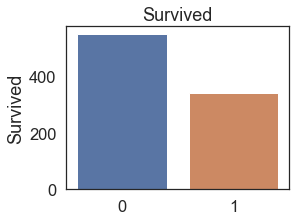

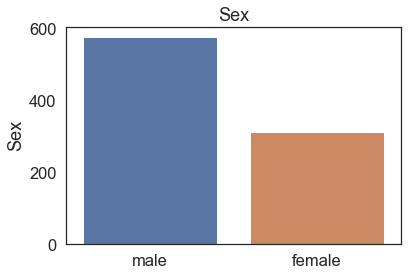

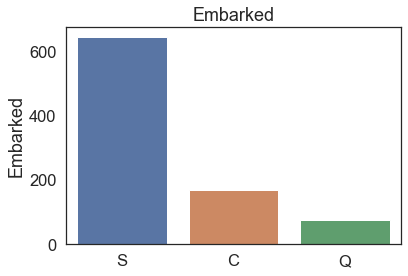

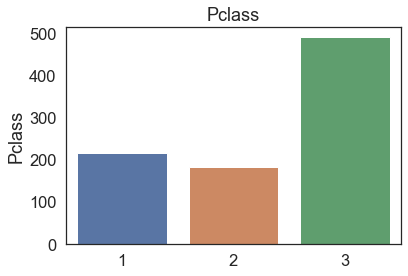

In [52]:
plt.figure(figsize=(4, 3))
review = train[['Survived', 'Sex', 'Embarked', 'Pclass']]
for i in review.columns:
    sns.barplot(x=review[i].value_counts().index, y=review[i].value_counts()).set_title(i)
    plt.show()

From the above visualization, it is clear that the non-survivors outnumber the survivors. There were more males than females on the ship. The port of embarkation of most people was Southampthon and people with 3rd class tickets were the majority on the ship.

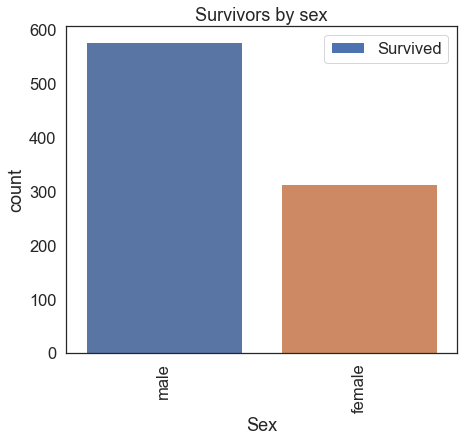

In [53]:
fig, axes = plt.subplots(1,1, figsize=(7,6))
train[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=axes)
axes.set_title('Survivors by sex')
sns.countplot('Sex', data=train, ax=axes)
plt.show()

The above viz concludes that men were more likely to survive than women in the shipwreck

### Feature Engineering and Further Exploration

For this project, the PassengerId, Cabin, Ticket, and Name columns will not be used. Hence, we'll drop them but we will keep `PassengerId` for the test set because it will be used for submission

In [54]:
train.drop(['Ticket', 'Cabin', 'Name', 'PassengerId'], axis='columns', inplace=True)

In [55]:
test.drop(['Ticket', 'Cabin', 'Name'], axis='columns', inplace=True)

In [56]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,male,34.5,0,0,7.8292,Q
1,893,3,female,47.0,1,0,7.0000,S
2,894,2,male,62.0,0,0,9.6875,Q
3,895,3,male,27.0,0,0,8.6625,S
4,896,3,female,22.0,1,1,12.2875,S


In [57]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [58]:
train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Recall that we still got some null values in our dataset. Lets see them

In [59]:
train.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

We can see that the Age and Embarked columns have null values. We will remove them in a minute

In [60]:
data = [train, test]
for dataset in data:
    mean = train['Age'].mean()
    std = train['Age'].std()
    is_null = dataset['Age'].isnull().sum()
    random_age = np.random.randint(mean-std, mean+std, size=is_null)
    age_rem = dataset['Age'].copy()
    age_rem[np.isnan(age_rem)] = random_age
    dataset['Age'] = age_rem
    dataset['Age'] = train['Age'].astype(int)
    train['Age'].isnull().sum()

In [61]:
train['Age'].isnull().sum()

0

For the Embarked column, we will replace the null values with the most frequent value

In [62]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [63]:
most_frequent = 'S'
data = [train, test]
for i in data:
    i['Embarked'] = i['Embarked'].fillna(most_frequent)

In [64]:
train['Embarked'].isnull().sum()

0

In [65]:
pd.pivot_table(train, index='Survived', values=['Age', 'SibSp', 'Parch', 'Fare', 'Pclass'])

,Age,Fare,Parch,Pclass,SibSp
Survived,,,,,
0,30.415301,22.117887,0.329690,2.531876,0.553734
1,28.432749,48.395408,0.464912,1.950292,0.473684


### Relationship between data

In [66]:
train.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.071387,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.343588,0.083081,0.018443,-0.549500
Age,-0.071387,-0.343588,1.000000,-0.215108,-0.175200,0.103763
SibSp,-0.035322,0.083081,-0.215108,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.175200,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.103763,0.159651,0.216225,1.000000


<AxesSubplot:>

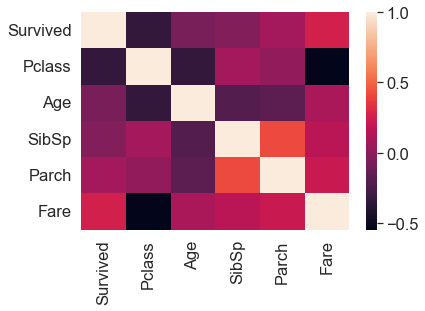

In [67]:
sns.heatmap(train.corr())

We can see that Siblings and Parents have a strong correlation

In [68]:
train.dtypes 

Survived      int64
Pclass        int64
Sex          object
Age           int32
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

The fare column is a float data type. We can turn it into an integer

In [69]:
data = [train, test]
for i in data:
    i['Fare'] = i['Fare'].fillna(0)
    # i['Fare'] = i['Fare'].astype(int)
print(i['Fare'].dtype)

float64


We can also review the test dataset to confirm it no longer has null values

In [70]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

From above, we can see that `Sex` and `Embarked` columns are of categorical variables. I will assign numerical values to them shortly.

Note: Most Machine Learning algorithms work well with numerical variables

In [71]:
embark_num = {'S': 1, 'C': 2, 'Q': 3}
train['Embarked'] = train['Embarked'].map(embark_num)
test['Embarked'] = test['Embarked'].map(embark_num)

sex_num = {'male': 0, 'female': 1}
train['Sex'] = train['Sex'].map(sex_num)
test['Sex'] = test['Sex'].map(sex_num)

We can now see that all our columns are of numerical variables

In [72]:
train.dtypes

Survived      int64
Pclass        int64
Sex           int64
Age           int32
SibSp         int64
Parch         int64
Fare        float64
Embarked      int64
dtype: object

In [73]:
train.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22,1,0,7.2500,1
1,1,1,1,38,1,0,71.2833,2


### Model Training

#### XGBoost

In [75]:
X_train = train.drop(['Survived'], axis='columns')
y_train = train['Survived']
X_test = test

In [76]:
from sklearn.model_selection import cross_validate

def cross_validation(model, _X, _y, _cv=5):
      '''Function to perform 5 Folds Cross-Validation
       Parameters
       ----------
      model: Python Class, default=None
              This is the machine learning algorithm to be used for training.
      _X: array
           This is the matrix of features.
      _y: array
           This is the target variable.
      _cv: int, default=5
          Determines the number of folds for cross-validation.
       Returns
       -------
       The function returns a dictionary containing the metrics 'accuracy', 'precision',
       'recall', 'f1' for both training set and validation set.
      '''
      _scoring = ['accuracy', 'precision', 'recall', 'f1']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return {"Training Accuracy scores": results['train_accuracy'],
              "Mean Training Accuracy": results['train_accuracy'].mean()*100,
              "Training Precision scores": results['train_precision'],
              "Mean Training Precision": results['train_precision'].mean(),
              "Training Recall scores": results['train_recall'],
              "Mean Training Recall": results['train_recall'].mean(),
              "Training F1 scores": results['train_f1'],
              "Mean Training F1 Score": results['train_f1'].mean(),
              "Validation Accuracy scores": results['test_accuracy'],
              "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
              "Validation Precision scores": results['test_precision'],
              "Mean Validation Precision": results['test_precision'].mean(),
              "Validation Recall scores": results['test_recall'],
              "Mean Validation Recall": results['test_recall'].mean(),
              "Validation F1 scores": results['test_f1'],
              "Mean Validation F1 Score": results['test_f1'].mean()
              }

In [77]:
def plot_result(x_label, y_label, plot_title, train_data, val_data):
        '''Function to plot a grouped bar chart showing the training and validation
          results of the ML model in each fold after applying K-fold cross-validation.
         Parameters
         ----------
         x_label: str, 
            Name of the algorithm used for training e.g 'Decision Tree'
          
         y_label: str, 
            Name of metric being visualized e.g 'Accuracy'
         plot_title: str, 
            This is the title of the plot e.g 'Accuracy Plot'
         
         train_result: list, array
            This is the list containing either training precision, accuracy, or f1 score.
        
         val_data: list, array
            This is the list containing either validation precision, accuracy, or f1 score.
         Returns
         -------
         The function returns a Grouped Barchart showing the training and validation result
         in each fold.
        '''
        
        # Set size of plot
        plt.figure(figsize=(12,6))
        labels = ["1st Fold", "2nd Fold", "3rd Fold", "4th Fold", "5th Fold",
                 "6th Fold", "7th Fold", "8th Fold", "9th Fold", "10th Fold"]
        X_axis = np.arange(len(labels))
        ax = plt.gca()
        plt.ylim(0.40000, 1)
        plt.bar(X_axis-0.2, train_data, 0.4, color='blue', label='Training')
        plt.bar(X_axis+0.2, val_data, 0.4, color='red', label='Validation')
        plt.title(plot_title, fontsize=30)
        plt.xticks(X_axis, labels)
        plt.xlabel(x_label, fontsize=14)
        plt.ylabel(y_label, fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.show()

In [78]:
xgb_classifier = xgb.XGBClassifier(learning_rate= 0.03, eval_metric='mlogloss', objective='reg:logistic')
xgb_result = cross_validation(xgb_classifier, X_train, y_train, 10)
xgb_result

{'Training Accuracy scores': array([0.88888889, 0.88653367, 0.91147132, 0.89027431, 0.88778055,
        0.88528678, 0.88778055, 0.8840399 , 0.88778055, 0.88528678]),
 'Mean Training Accuracy': 88.95123302853976,
 'Training Precision scores': array([0.90977444, 0.90943396, 0.92779783, 0.91044776, 0.90977444,
        0.91860465, 0.91923077, 0.91187739, 0.91287879, 0.91505792]),
 'Mean Training Precision': 0.9144877947539929,
 'Training Recall scores': array([0.78827362, 0.78246753, 0.83441558, 0.79220779, 0.78571429,
        0.76948052, 0.77597403, 0.77272727, 0.78246753, 0.77198697]),
 'Mean Training Recall': 0.7855715131773764,
 'Training F1 scores': array([0.84467714, 0.84118674, 0.87863248, 0.84722222, 0.84320557,
        0.83745583, 0.8415493 , 0.83655536, 0.84265734, 0.83745583]),
 'Mean Training F1 Score': 0.8450597809603713,
 'Validation Accuracy scores': array([0.74444444, 0.82022472, 0.75280899, 0.8988764 , 0.88764045,
        0.86516854, 0.87640449, 0.7752809 , 0.87640449, 0.8

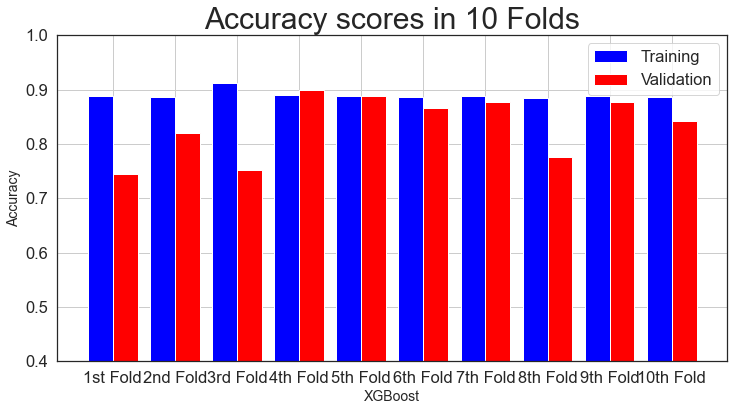

In [80]:
model_name = "XGBoost"
plot_result(model_name, "Accuracy", "Accuracy scores in 10 Folds", xgb_result["Training Accuracy scores"], 
            xgb_result["Validation Accuracy scores"])

In [97]:
lr = cross_validate(xgb_classifier, X_train, y_train, cv=10, return_train_score=True)
lr

{'fit_time': array([0.29521012, 0.26111364, 0.23432064, 0.2207489 , 0.22071004,
        0.21869469, 0.23431969, 0.2476449 , 0.23431969, 0.2343204 ]),
 'score_time': array([0.00897694, 0.        , 0.        , 0.01562381, 0.01562381,
        0.01562262, 0.        , 0.00163341, 0.        , 0.        ]),
 'test_score': array([0.74444444, 0.82022472, 0.75280899, 0.8988764 , 0.88764045,
        0.86516854, 0.87640449, 0.7752809 , 0.87640449, 0.84269663]),
 'train_score': array([0.88888889, 0.88653367, 0.91147132, 0.89027431, 0.88778055,
        0.88528678, 0.88778055, 0.8840399 , 0.88778055, 0.88528678])}

In [100]:
lr['train_score'].mean()*100

88.95123302853976

In [101]:
lr['test_score'].mean()*100

83.39950062421971

In [114]:
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test.drop('PassengerId', axis=1))

In [115]:
out = test['PassengerId']
test_predictions = y_pred_xgb
output = pd.DataFrame({
    'PassengerId': out, 'Survived': test_predictions
})
output.to_csv('prediction_submission2.csv', index=False)

In [116]:
# cb_classifier = cb.CatBoostClassifier(iterations=10, learning_rate=1, depth=5, l2_leaf_reg=7)
# cb_result = cross_validation(cb_classifier, X_train, y_train, 10)
# cb_result